# FA profile based moa prediction

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [71]:
import pickle

import pyarrow
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

# Data

In [88]:
try:
    paths = snakemake.input.paths
    labels_path = snakemake.input.labels
except NameError:
    data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021")
    data_dir = data_root / "results" / "scip" / "allweeks"
    path = data_dir / "features.parquet"
    labels_path = data_dir.parent / "labels.parquet"
    moa_path = data_root / "BBBC021_v1_moa.csv"
    image_path = data_root / "BBBC021_v1_image.csv"

In [89]:
moa = pandas.read_csv(moa_path)
image = pandas.read_csv(image_path)

In [90]:
moa_image = moa.merge(
    image,
    left_on=["compound", "concentration"],
    right_on=["Image_Metadata_Compound", "Image_Metadata_Concentration"]
).drop(columns=["Image_Metadata_Compound", "Image_Metadata_Concentration"])

In [91]:
moa_image["batch"] = moa_image["Image_Metadata_Plate_DAPI"].apply(lambda p: int(p.split("_")[0][len("Week"):])).astype('category')

<AxesSubplot:xlabel='batch', ylabel='moa'>

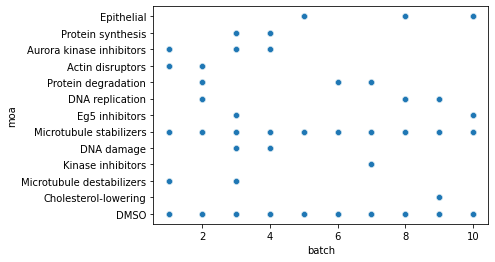

In [92]:
seaborn.scatterplot(data=moa_image, x="batch", y="moa")

To apply the Not-same-compound-or-batch approach by [Ando et al.](https://www.biorxiv.org/content/10.1101/161422v1.full.pdf), the Cholesterol-lowering and Kinase Inhibitors MOAs should be removed from the datasets as they are only present on one batch.

In [93]:
moa_image = moa_image[~moa_image["moa"].isin(["Cholesterol-lowering", "Kinase inhibitors"])]

<AxesSubplot:xlabel='batch', ylabel='compound'>

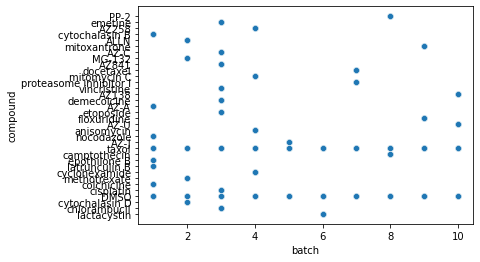

In [94]:
seaborn.scatterplot(data=moa_image, x="batch", y="compound")

In [95]:
treatments = moa_image[~moa_image["compound"].isin(["DMSO"])]

According to the previously mentioned research 92 treatments should remain.

In [96]:
(treatments["compound"] + treatments["concentration"].astype(str)).unique().shape

(92,)

In [97]:
%%time
df = pq.read_table(path).to_pandas()

CPU times: user 7.8 s, sys: 5.41 s, total: 13.2 s
Wall time: 21.2 s


In [98]:
df.columns[df.isna().all()]

Index([], dtype='object')

In [99]:
df.shape

(1255609, 677)

In [100]:
df = df.fillna(0)

In [101]:
df = df[~df.isna().any(axis=1)]
df.shape

(1255609, 677)

In [102]:
moa_image.columns = ["meta_" + c for c in moa_image.columns]

In [103]:
df = df.merge(moa_image, left_on="meta_filename", right_on="meta_Image_FileName_DAPI")

# Removing interplate variation

In [104]:
qq_dmso = df[df["meta_moa"] == "DMSO"].groupby("meta_Image_Metadata_Plate_DAPI")[df.filter(regex="feat").columns].quantile((0.01, 0.99))

In [105]:
dfs = []
for idx, gdf in df.groupby("meta_Image_Metadata_Plate_DAPI"):
    print(idx)
    df_scaled = (gdf.filter(regex="feat") - qq_dmso.loc[idx, 0.01]) / (qq_dmso.loc[idx, 0.99] - qq_dmso.loc[idx, 0.01])
    df_scaled = pandas.concat([df_scaled, gdf.filter(regex="meta")], axis=1)
    
    dfs.append(df_scaled)

Week1_22161
Week1_22361
Week1_22381
Week1_22401
Week2_24121
Week2_24141
Week2_24161
Week2_24361
Week2_24381
Week2_24401
Week3_25421
Week3_25441
Week4_27521
Week4_27542
Week4_27801
Week4_27821
Week4_27861
Week5_28901
Week6_31641
Week6_31661
Week6_31681
Week6_32061
Week6_32121
Week6_32161
Week7_34341
Week7_34381
Week7_34641
Week7_34661
Week7_34681
Week8_38203
Week8_38221
Week8_38241
Week8_38341
Week8_38342
Week9_39206
Week9_39221
Week9_39222
Week9_39282
Week9_39283
Week9_39301


In [106]:
df = pandas.concat(dfs)
del dfs

In [107]:
df.columns[df.isna().all()]

Index(['feat_euler_number_combined', 'feat_euler_number_actin',
       'feat_euler_number_tubulin'],
      dtype='object')

In [108]:
nancols = df.columns[df.isna().any()]
nancols

Index(['feat_euler_number_combined', 'feat_euler_number_actin',
       'feat_euler_number_tubulin'],
      dtype='object')

In [109]:
df = df.drop(columns=nancols)

# Converting per-cell profiles to treatment profiles

In [33]:
fa = FactorAnalysis(random_state=0, n_components=50)

In [34]:
%%time
fa.fit(df[df["meta_compound"] == "DMSO"].filter(regex="feat").sample(n=50000))

CPU times: user 36.4 s, sys: 712 ms, total: 37.1 s
Wall time: 37.3 s


FactorAnalysis(n_components=50)

In [110]:
%%time
dfs = []
for idx, gdf in df[df["meta_moa"] != "DMSO"].groupby(["meta_compound", "meta_concentration"]):
#     tmp_df = pandas.Series(data=fa.transform(gdf.filter(regex="feat")).mean(axis=0))
    tmp_df = pandas.Series(data=gdf.filter(regex="feat").mean(axis=0))
    tmp_df.index = ["feat_"+str(c) for c in tmp_df.index]
    tmp_df["meta_compound"] = idx[0]
    tmp_df["meta_concentration"] = idx[1]
    tmp_df["meta_moa"] = gdf["meta_moa"].iloc[0]
    tmp_df["meta_batch"] = gdf["meta_batch"].iloc[0]
    dfs.append(tmp_df)
    
mu = pandas.DataFrame(dfs)

CPU times: user 769 ms, sys: 89.5 ms, total: 859 ms
Wall time: 863 ms


In [111]:
del dfs

In [112]:
mu.shape

(69, 669)

In [113]:
treatment_profiles = mu

# Exploration

In [114]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [115]:
dimred = PCA().fit_transform(treatment_profiles.filter(regex="feat"))

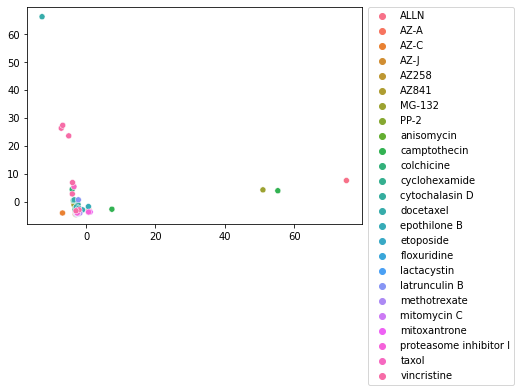

In [116]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_compound"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

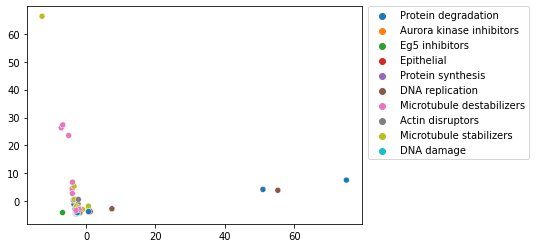

In [117]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_moa"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [118]:
from umap import UMAP

In [119]:
dimred = UMAP(metric="cosine", min_dist=0.5, n_neighbors=8, random_state=0).fit_transform(treatment_profiles.filter(regex="feat"))

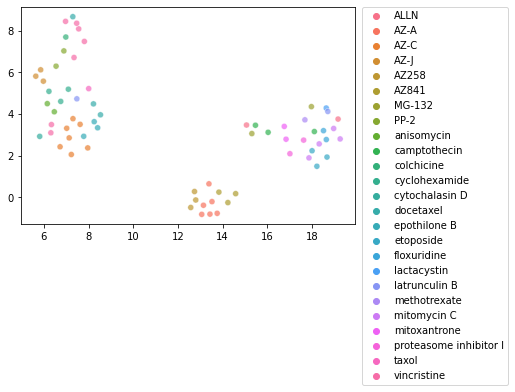

In [120]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_compound"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

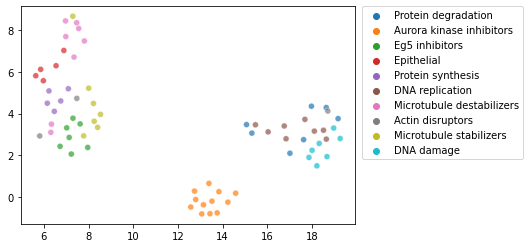

In [121]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_moa"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Classification

In [122]:
true = []
preds = []

for idx, gdf in treatment_profiles.groupby("meta_compound"):
    test_compounds = treatment_profiles[treatment_profiles["meta_batch"].isin(gdf["meta_batch"].unique())]["meta_compound"].unique()
    test_index = treatment_profiles["meta_compound"].isin(test_compounds)
    
    e = KNeighborsClassifier(n_neighbors=1, metric="cosine")
    e.fit(
        X=treatment_profiles.filter(regex="feat")[~test_index],
        y=treatment_profiles[~test_index]["meta_moa"]
    )
    
    true.extend(gdf["meta_moa"])
    preds.extend(e.predict(gdf.filter(regex="feat")))

In [123]:
accuracy_score(true, preds)

0.4927536231884058

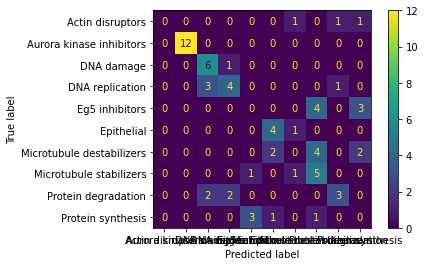

In [124]:
ConfusionMatrixDisplay.from_predictions(true, preds)

# Predictions

In [12]:
treatment_profiles = df[df["meta_compound"] != "DMSO"].groupby(["meta_compound", "meta_concentration"]).size().index.to_frame()
treatment_profiles = treatment_profiles.drop(columns=treatment_profiles.columns)
treatment_profiles.index.names = ["compound", "concentration"]

In [13]:
moa = pandas.read_csv(moa_path).set_index(["compound", "concentration"])

In [14]:
treatment_profiles = treatment_profiles.merge(moa, left_index=True, right_index=True)

In [15]:
with open(data_dir / "fa3.pickle", "rb") as fh:
    grid = pickle.load(fh)

In [16]:
treatment_profiles = treatment_profiles.reset_index()

In [17]:
metrics = []
for a in grid:
    preds = numpy.empty_like(a[1])
    true = numpy.empty_like(a[1])
    true_labels = []
    pred_labels = []
    for i, (train_index, test_index) in enumerate(LeaveOneGroupOut().split(
        treatment_profiles, 
        treatment_profiles["moa"], 
        treatment_profiles["compound"]
    )):
        true[i, train_index] = treatment_profiles["moa"].iloc[train_index]
        true[i, test_index] = treatment_profiles["moa"].iloc[test_index]
        
        preds[i, train_index] = a[1][i, train_index]
        preds[i, test_index] = a[1][i, test_index]
        
        true_labels.extend(true[i, test_index])
        pred_labels.extend(preds[i, test_index])
    metrics.append(dict(
        n=a[0], 
        balanced_accuracy=balanced_accuracy_score(true_labels, pred_labels),
        accuracy=accuracy_score(true_labels, pred_labels),
        confusion_matrix=confusion_matrix(true_labels, pred_labels)))

In [18]:
metrics = pandas.DataFrame(metrics)

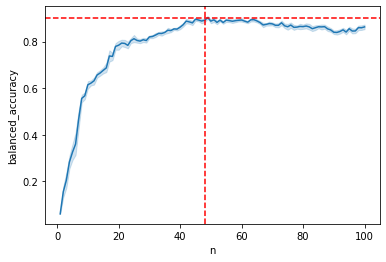

In [25]:
ax = seaborn.lineplot(data=metrics, x="n", y="balanced_accuracy")
ax.axvline(metrics.groupby("n")["balanced_accuracy"].mean().argmax(), linestyle="--", color="red")
ax.axhline(metrics.groupby("n")["balanced_accuracy"].mean().max(), linestyle="--", color="red")

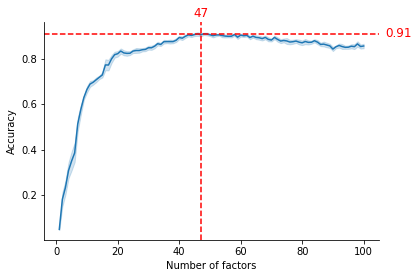

In [19]:
ax = seaborn.lineplot(data=metrics, x="n", y="accuracy")

s = metrics.groupby("n")["accuracy"].mean()
a, b = s.argmax(), s.max()
ax.axvline(a, linestyle="--", color="red")
ax.axhline(b, linestyle="--", color="red")

ax.text(x=ax.get_xlim()[1]+2, y=b, s='%.2f' % b, va="center", ha="left", color="red", fontsize=12)
ax.text(x=a, y=ax.get_ylim()[1]+0.01, s='%2.d' % a, va="bottom", ha="center", color="red", fontsize=12)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of factors")

seaborn.despine(ax=ax)

# plt.savefig(data_dir / "figures" / "bbbc_optimize_scip.png", dpi=300, bbox_inches="tight")

In [20]:
cm = numpy.asarray(metrics["confusion_matrix"][metrics["n"] == 48].tolist()).sum(axis=0) / 20
cm = numpy.round(numpy.where(cm < 0.5, 0, cm))

Text(14, 12, 'Overall Acc.:90%')

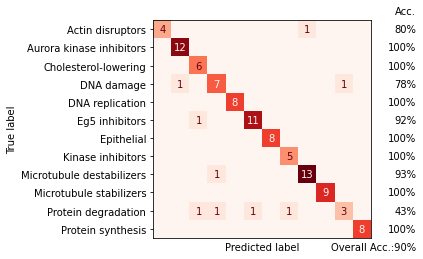

In [21]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=sorted(treatment_profiles["moa"].unique())).plot(ax=ax, colorbar=False, cmap="Reds")

for child in ax.get_children():
    if isinstance(child, matplotlib.text.Text) and child._text == '0':
        child.set_visible(False)

ax.set_xticks([])

acc = (numpy.diag(cm)*100 / cm.sum(axis=1))
for i in range(len(cm)):
    ax.text(x=14, y=i, s='%.0f%%' % acc[i], va="center", ha="right")
ax.text(x=14, y=-1, s='Acc.', va="center", ha="right")
ax.text(x=14, y=12, s='Overall Acc.:%.0f%%' % numpy.mean(acc), va="center", ha="right")

# plt.savefig(data_dir / "figures" / "bbbc_confmat_scip.png", dpi=300, bbox_inches="tight")